In [29]:
# 01 - Data Cleaning and Preparation

#This notebook loads the Amazon sales dataset, performs data cleaning, and prepares it for analysis and modeling.

In [35]:
# Import all required Python libraries for data analysis.
# - pandas: for data manipulation
# - numpy: for numerical operations
# - matplotlib & seaborn: for visualizations

# 1. Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Add src folder to path
import sys
sys.path.append('../src')

# 3. Import project functions
from data_cleaning import convert_dates, calculate_discounts, handle_missing_values
from eda_functions import missing_values, summarize_numeric
from visualization_utils import plot_monthly_revenue
from forecasting_utils import prepare_prophet_data

In [32]:
# Load the Amazon sales dataset from the local file path.
# The dataset contains order, pricing, discount, and customer info.
# df.head() displays the first 5 rows to confirm successful loading.

data_path = "../data/amazon_sales_dataset.csv"
df = pd.read_csv(data_path)
df.head()

,order_id,order_date,product_id,product_category,price,discount_percent,quantity_sold,customer_region,payment_method,rating,review_count,discounted_price,total_revenue
0,1,2022-04-13,2637,Books,128.75,10,4,North America,UPI,3.5,443,115.88,463.52
1,2,2023-03-12,2300,Fashion,302.60,20,5,Asia,Credit Card,3.7,475,242.08,1210.40
2,3,2022-09-28,3670,Sports,495.80,20,2,Europe,UPI,4.4,183,396.64,793.28
3,4,2022-04-17,2522,Books,371.95,15,4,Middle East,UPI,5.0,212,316.16,1264.64
4,5,2022-03-13,1717,Beauty,201.68,0,4,Middle East,UPI,4.6,308,201.68,806.72


In [6]:
# Check Dataset Shape
# Check the number of rows and columns in the dataset.
# This helps confirm the dataset loaded correctly and gives
# an idea of the dataset size before cleaning.
df.shape

(50000, 13)

In [7]:
#Check Missing Values
# Identify missing values in each column.
# This step helps determine which columns need cleaning,
# imputation, or removal.
df.isnull().sum()

order_id            0
order_date          0
product_id          0
product_category    0
price               0
discount_percent    0
quantity_sold       0
customer_region     0
payment_method      0
rating              0
review_count        0
discounted_price    0
total_revenue       0
dtype: int64

In [8]:
#Convert order_date to datetime
# Convert the 'order_date' column from string to datetime format.
# This is required for time-series analysis and forecasting.
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_date'].head()


0   2022-04-13
1   2023-03-12
2   2022-09-28
3   2022-04-17
4   2022-03-13
Name: order_date, dtype: datetime64[ns]

In [9]:
#Create New Date Features
# Create additional date-related features for analysis:
# - year
# - month
# - day of week
# These help in identifying sales trends and seasonality.
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day_of_week'] = df['order_date'].dt.day_name()

df[['order_date', 'year', 'month', 'day_of_week']].head()


,order_date,year,month,day_of_week
0,2022-04-13,2022,4,Wednesday
1,2023-03-12,2023,3,Sunday
2,2022-09-28,2022,9,Wednesday
3,2022-04-17,2022,4,Sunday
4,2022-03-13,2022,3,Sunday


In [10]:
# -------------------------------------------------------------
# 4. VALIDATE REVENUE & DISCOUNT CALCULATIONS
# -------------------------------------------------------------

# Recalculate discounted_price if needed
df['calculated_discounted_price'] = df['price'] * (1 - df['discount_percent'] / 100)

# Compare with existing discounted_price
df[['price', 'discount_percent', 'discounted_price', 'calculated_discounted_price']].head()

# Recalculate total_revenue
df['calculated_total_revenue'] = df['calculated_discounted_price'] * df['quantity_sold']

# Compare with existing total_revenue
df[['total_revenue', 'calculated_total_revenue']].head()

,total_revenue,calculated_total_revenue
0,463.52,463.50
1,1210.40,1210.40
2,793.28,793.28
3,1264.64,1264.63
4,806.72,806.72


In [11]:
# 2. Exploratory data analysis (EDA

# 1. BASIC STATISTICS
df.describe(include='all')


,order_id,order_date,product_id,product_category,price,discount_percent,quantity_sold,customer_region,payment_method,rating,review_count,discounted_price,total_revenue,year,month,day_of_week,calculated_discounted_price,calculated_total_revenue
count,50000.000000,50000,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0000,50000,50000.000000,50000.000000
unique,NaN,NaN,NaN,6,NaN,NaN,NaN,4,5,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,Beauty,NaN,NaN,NaN,Asia,Wallet,NaN,NaN,NaN,NaN,NaN,NaN,Friday,NaN,NaN
freq,NaN,NaN,NaN,8465,NaN,NaN,NaN,12526,10106,NaN,NaN,NaN,NaN,NaN,NaN,7317,NaN,NaN
mean,25000.500000,2022-12-31 10:47:16.800000256,2986.848740,NaN,252.507260,13.340700,2.999400,NaN,NaN,2.996316,249.329280,218.886566,657.331475,2022.501480,6.5044,NaN,218.886599,657.331591
min,1.000000,2022-01-01 00:00:00,1000.000000,NaN,5.010000,0.000000,1.000000,NaN,NaN,1.000000,0.000000,3.530000,3.840000,2022.000000,1.0000,NaN,3.528000,3.843000
25%,12500.750000,2022-07-02 00:00:00,1983.000000,NaN,127.840000,5.000000,2.000000,NaN,NaN,2.000000,125.000000,109.680000,240.320000,2022.000000,4.0000,NaN,109.677000,240.320625
50%,25000.500000,2023-01-02 00:00:00,2983.000000,NaN,252.970000,10.000000,3.000000,NaN,NaN,3.000000,250.000000,215.805000,505.410000,2023.000000,7.0000,NaN,215.805500,505.407000
75%,37500.250000,2023-07-02 00:00:00,3989.000000,NaN,376.335000,20.000000,4.000000,NaN,NaN,4.000000,374.000000,322.702500,968.970000,2023.000000,9.0000,NaN,322.705375,968.966250
max,50000.000000,2023-12-31 00:00:00,4999.000000,NaN,499.990000,30.000000,5.000000,NaN,NaN,5.000000,499.000000,499.910000,2499.550000,2023.000000,12.0000,NaN,499.910000,2499.550000


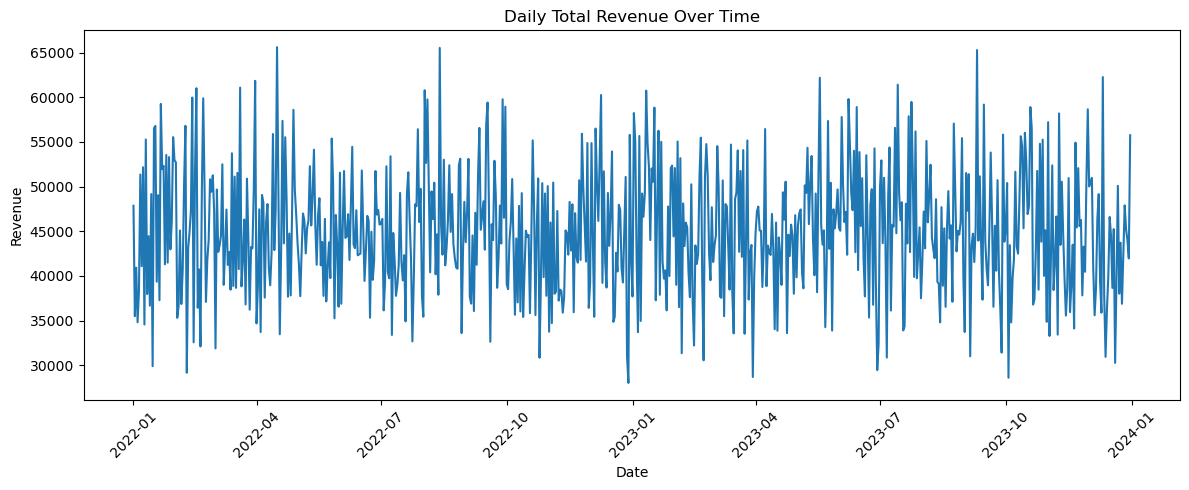

In [12]:

# 2. SALES TRENDS OVER TIME
# Aggregate daily revenue
daily_sales = df.groupby('order_date')['total_revenue'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(daily_sales['order_date'], daily_sales['total_revenue'])
plt.title('Daily Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


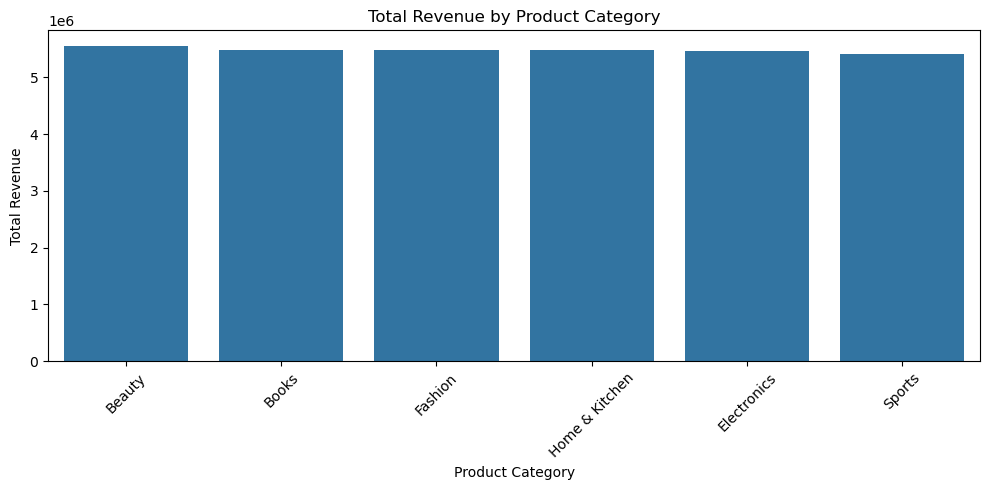

In [13]:

# 3. PRODUCT CATEGORY PERFORMANCE
category_sales = df.groupby('product_category')['total_revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=category_sales.index, y=category_sales.values)
plt.title('Total Revenue by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



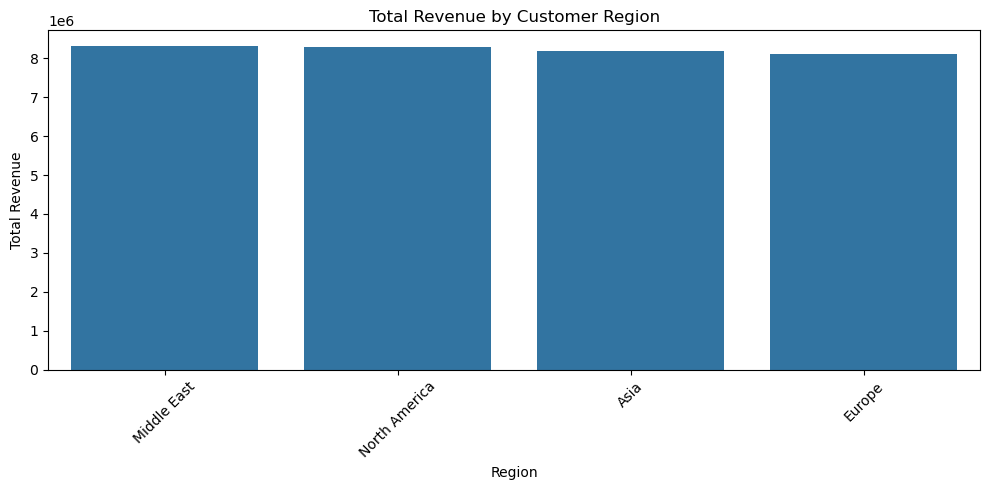

In [14]:
# 4. REGIONAL CUSTOMER BEHAVIOR
region_sales = df.groupby('customer_region')['total_revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=region_sales.index, y=region_sales.values)
plt.title('Total Revenue by Customer Region')
plt.xlabel('Region')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


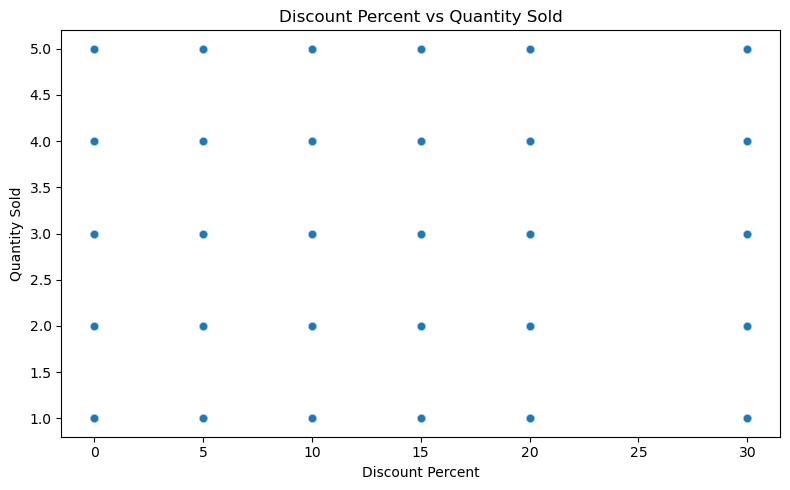

In [15]:
# 5. DISCOUNT IMPACT ON QUANTITY SOLD
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='discount_percent', y='quantity_sold', alpha=0.3)
plt.title('Discount Percent vs Quantity Sold')
plt.xlabel('Discount Percent')
plt.ylabel('Quantity Sold')
plt.tight_layout()
plt.show()


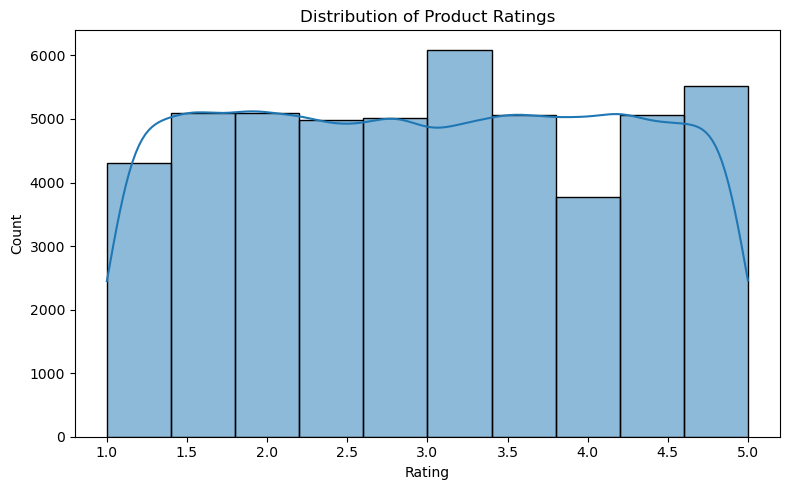

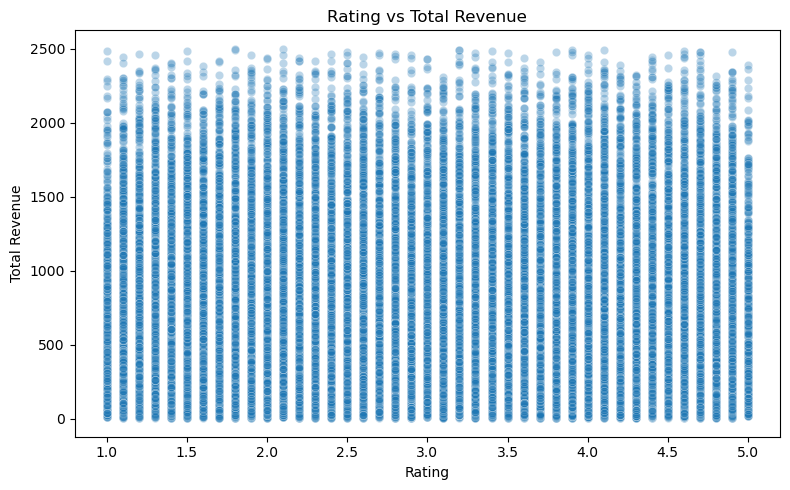

In [16]:
# 6. RATINGS & REVIEW PATTERNS
plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], bins=10, kde=True)
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='rating', y='total_revenue', alpha=0.3)
plt.title('Rating vs Total Revenue')
plt.xlabel('Rating')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()


In [17]:
# No 3 Data visualization (already embedded above
#Monthly revenue
#Heatmap of categories vs regions

# But will first Create a year-month column for monthly grouping


df['year_month'] = df['order_date'].dt.to_period('M').astype(str)

df[['order_date', 'year_month']].head()


,order_date,year_month
0,2022-04-13,2022-04
1,2023-03-12,2023-03
2,2022-09-28,2022-09
3,2022-04-17,2022-04
4,2022-03-13,2022-03


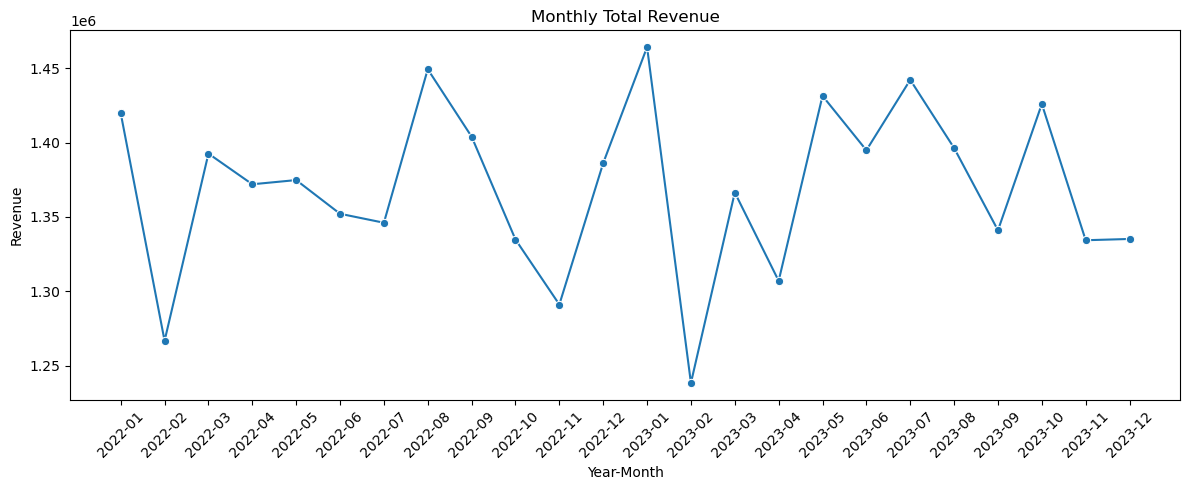

In [18]:
#Monthly revenue
monthly_sales = df.groupby('year_month')['total_revenue'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_sales, x='year_month', y='total_revenue', marker='o')
plt.title('Monthly Total Revenue')
plt.xlabel('Year-Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# N0 4 Feature Engineering
#1. DISCOUNT AMOUNT & EFFECTIVE PRICE
df['discount_amount'] = df['price'] * df['discount_percent'] / 100
df['effective_price'] = df['price'] - df['discount_amount']

df[['price', 'discount_percent', 'discount_amount', 'effective_price']].head()


,price,discount_percent,discount_amount,effective_price
0,128.75,10,12.8750,115.8750
1,302.60,20,60.5200,242.0800
2,495.80,20,99.1600,396.6400
3,371.95,15,55.7925,316.1575
4,201.68,0,0.0000,201.6800


In [20]:
# 2. REVENUE PER UNIT & REVENUE PER ORDER
df['revenue_per_unit'] = df['total_revenue'] / df['quantity_sold']
df[['total_revenue', 'quantity_sold', 'revenue_per_unit']].head()


,total_revenue,quantity_sold,revenue_per_unit
0,463.52,4,115.88
1,1210.40,5,242.08
2,793.28,2,396.64
3,1264.64,4,316.16
4,806.72,4,201.68


In [21]:
# 3. AGGREGATED TIME-SERIES FOR FORECASTING
# Aggregate daily revenue for forecasting
ts_daily = df.groupby('order_date')['total_revenue'].sum().reset_index()
ts_daily = ts_daily.sort_values('order_date')

ts_daily.head()


,order_date,total_revenue
0,2022-01-01,47860.37
1,2022-01-02,35499.55
2,2022-01-03,40929.87
3,2022-01-04,34813.73
4,2022-01-05,38316.72


In [22]:

# Create daily aggregated time-series for forecasting

ts_daily = df.groupby('order_date')['total_revenue'].sum().reset_index()

# Sort by date just to be safe
ts_daily = ts_daily.sort_values('order_date')

ts_daily.head()

,order_date,total_revenue
0,2022-01-01,47860.37
1,2022-01-02,35499.55
2,2022-01-03,40929.87
3,2022-01-04,34813.73
4,2022-01-05,38316.72


In [23]:
# No 5 Sales forecasting (Prophet example)
# 1. PREPARE DATA FOR PROPHET

from prophet import Prophet

# Prophet expects columns: ds (date), y (value)
prophet_df = ts_daily.rename(columns={'order_date': 'ds', 'total_revenue': 'y'})

prophet_df.head()


,ds,y
0,2022-01-01,47860.37
1,2022-01-02,35499.55
2,2022-01-03,40929.87
3,2022-01-04,34813.73
4,2022-01-05,38316.72


In [24]:
# 2. TRAIN PROPHET MODEL

model = Prophet()
model.fit(prophet_df)

11:49:24 - cmdstanpy - INFO - Chain [1] start processing
11:49:27 - cmdstanpy - INFO - Chain [1] done processing


In [25]:

# 3. CREATE FUTURE DATES & FORECAST

future = model.make_future_dataframe(periods=90)  # next 90 days
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
815,2024-03-26,44211.605607,35384.404193,52875.754244
816,2024-03-27,44263.963382,35445.458030,53769.762534
817,2024-03-28,44573.899077,35701.919870,53467.873954
818,2024-03-29,46754.543233,37956.776301,56165.248618
819,2024-03-30,44857.551303,36054.223201,53253.197171


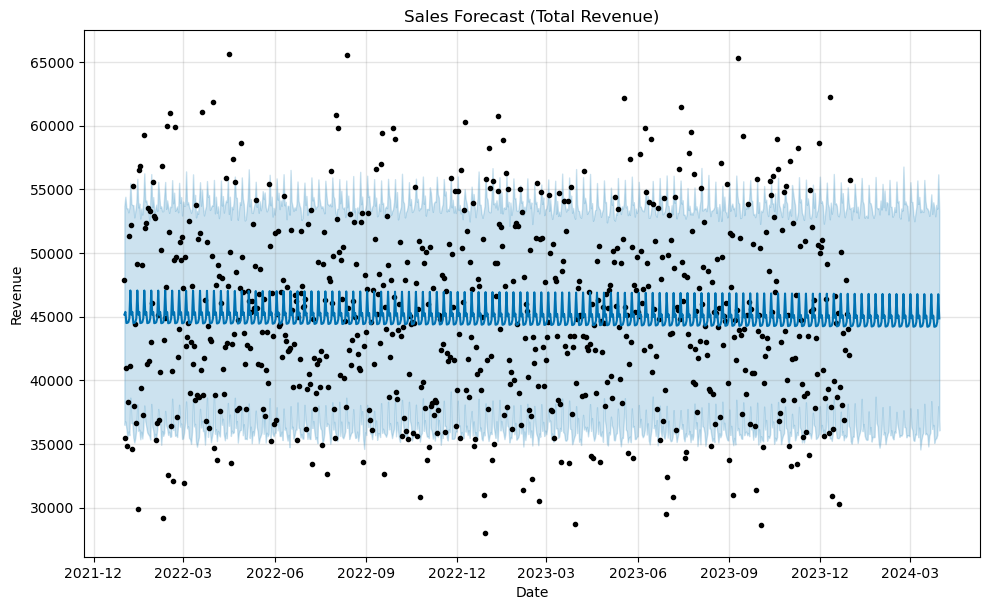

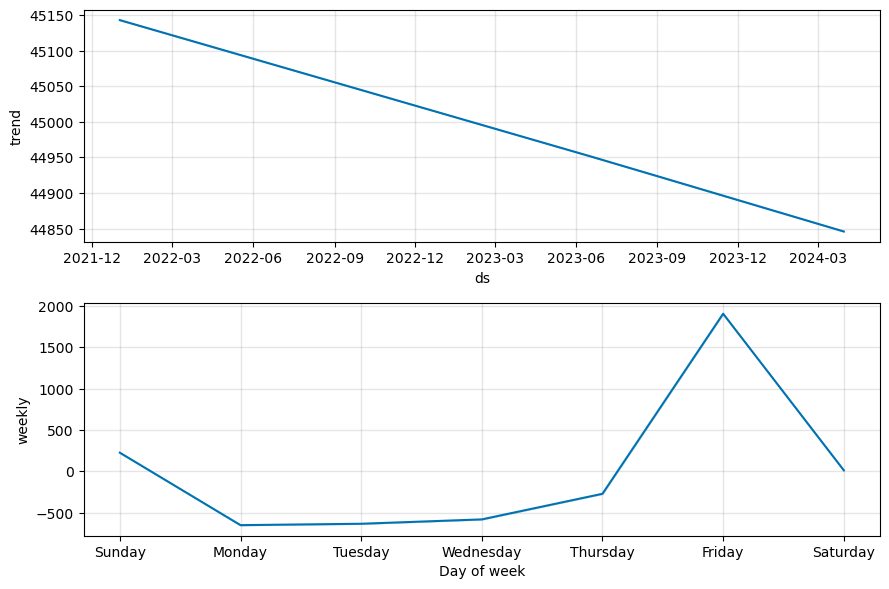

In [26]:
# 4. PLOT FORECAST

fig1 = model.plot(forecast)
plt.title('Sales Forecast (Total Revenue)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()